In [ ]:
# Install "numpy scipy matplotlib ipython pandas sympy" libraries via pip
import sys
!pip install --user numpy scipy pandas sympy

In [ ]:
# Install scikit-learn via pip
import sys
!pip install -U scikit-learn

In [ ]:
# Install themis-ml via pip
# If this does not work, then you can install this library manually: try forllowing steps from your own terminal
# cd <to this directory>
# sudo python themis-ml/setup.py build
# sudo python themis-ml/setup.py install

import sys
!pip install --user themis-ml

In [1]:
# Importing all libraries
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from themis_ml.preprocessing.relabelling import Relabeller
from themis_ml.meta_estimators import FairnessAwareMetaEstimator
from themis_ml.linear_model.counterfactually_fair_models import LinearACFClassifier
from themis_ml.postprocessing.reject_option_classification import SingleROClassifier
from themis_ml import datasets
from themis_ml.datasets.census_income_data_map import preprocess_census_income_data
import util as u

In [2]:
census_income = datasets.census_income(True)
census_income[["income_gt_50k", "citizenship", "marital_stat", "education"]].head()

,income_gt_50k,citizenship,marital_stat,education
0,0,native-_born_in_the_united_states,widowed,9
1,0,native-_born_in_the_united_states,divorced,10
2,0,foreign_born-_not_a_citizen_of_u_s,never_married,6
3,0,native-_born_in_the_united_states,never_married,0
4,0,native-_born_in_the_united_states,never_married,0


In [3]:
census_income_preprocessed = (
    preprocess_census_income_data(census_income)
    .assign(foreign_worker=lambda df: df["citizenship_native-_born_in_the_united_states"] != 0)
    .assign(age_below_25=lambda df: df['age'] <= 25)
    .assign(widowed=lambda df: df["marital_stat_widowed"])
)

In [4]:
print 'income_gt_50k'
income_gt_50k = census_income_preprocessed.income_gt_50k
income_gt_50k.value_counts()

income_gt_50k


0    280717
1     18568
Name: income_gt_50k, dtype: int64

In [5]:
print 'widowed'
is_widowed = census_income_preprocessed.widowed
print is_widowed.value_counts()

widowed
0    283497
1     15788
Name: widowed, dtype: int64


In [6]:
print 'foreign'
is_foreign = census_income_preprocessed.foreign_worker
print is_foreign.value_counts()

foreign
True     265347
False     33938
Name: foreign_worker, dtype: int64


In [7]:
print 'age_below_25'
age_below_25 = census_income_preprocessed.age_below_25
print age_below_25.value_counts()

age_below_25
False    184543
True     114742
Name: age_below_25, dtype: int64


In [8]:
# specify feature set. Note that we're excluding the `is_widowed`
# and `age_below_25` columns that we created above.

feature_set_1 = [
    'age',
    'wage_per_hour',
    'capital_gains',
    'capital_losses',
    'dividends_from_stocks',
    'num_persons_worked_for_employer',
    'weeks_worked_in_year',
    'education',
    'year',
    'class_of_worker_federal_government',
    'class_of_worker_local_government',
    'class_of_worker_never_worked',
    'class_of_worker_not_in_universe',
    'class_of_worker_private',
    'class_of_worker_self-employed-incorporated',
    'class_of_worker_self-employed-not_incorporated',
    'class_of_worker_state_government',
    'class_of_worker_without_pay',
    'enroll_in_edu_inst_last_wk_college_or_university',
    'enroll_in_edu_inst_last_wk_high_school',
    'enroll_in_edu_inst_last_wk_not_in_universe',
    'marital_stat_divorced',
    'marital_stat_married-a_f_spouse_present',
    'marital_stat_married-civilian_spouse_present',
    'marital_stat_married-spouse_absent',
    'marital_stat_never_married',
    'marital_stat_separated',
    'marital_stat_widowed',
    'major_occupation_code_adm_support_including_clerical',
    'major_occupation_code_armed_forces',
    'major_occupation_code_executive_admin_and_managerial',
    'major_occupation_code_farming_forestry_and_fishing',
    'major_occupation_code_handlers_equip_cleaners_etc',
    'major_occupation_code_machine_operators_assmblrs_&_inspctrs',
    'major_occupation_code_not_in_universe',
    'major_occupation_code_other_service',
    'major_occupation_code_precision_production_craft_&_repair',
    'major_occupation_code_private_household_services',
    'major_occupation_code_professional_specialty',
    'major_occupation_code_protective_services',
    'major_occupation_code_sales',
    'major_occupation_code_technicians_and_related_support',
    'major_occupation_code_transportation_and_material_moving',
    'race_amer_indian_aleut_or_eskimo',
    'race_asian_or_pacific_islander',
    'race_black',
    'race_other',
    'race_white',
    'sex_female',
    'sex_male',
    'live_in_this_house_1_year_ago_no',
    'live_in_this_house_1_year_ago_not_in_universe_under_1_year_old',
    'live_in_this_house_1_year_ago_yes',
    'migration_prev_res_in_sunbelt_?',
    'migration_prev_res_in_sunbelt_no',
    'migration_prev_res_in_sunbelt_not_in_universe',
    'migration_prev_res_in_sunbelt_yes',
    'family_members_under_18_both_parents_present',
    'family_members_under_18_father_only_present',
    'family_members_under_18_mother_only_present',
    'family_members_under_18_neither_parent_present',
    'family_members_under_18_not_in_universe',
    'citizenship_foreign_born-_not_a_citizen_of_u_s',
    'citizenship_foreign_born-_u_s_citizen_by_naturalization',
    'citizenship_native-_born_abroad_of_american_parent(s)',
    'citizenship_native-_born_in_puerto_rico_or_u_s_outlying',
    'citizenship_native-_born_in_the_united_states',
    'own_business_or_self_employed_no',
    'own_business_or_self_employed_not_in_universe',
    'own_business_or_self_employed_yes',
    'fill_inc_questionnaire_for_veteran\'s_admin_no',
    'fill_inc_questionnaire_for_veteran\'s_admin_not_in_universe',
    'fill_inc_questionnaire_for_veteran\'s_admin_yes',
    'veterans_benefits_no',
    'veterans_benefits_not_in_universe',
    'veterans_benefits_yes'
]

In [9]:
#################################################
# Case 1: Baseline
#################################################

# training and target data
train_set = census_income_preprocessed[census_income_preprocessed['dataset_partition'] == 'training_set']
test_set = census_income_preprocessed[census_income_preprocessed['dataset_partition'] == 'test_set']

X_train = train_set[feature_set_1].values
y_train = train_set["income_gt_50k"].values
s_widowed_train = train_set["widowed"].values
s_foreign_train = train_set["foreign_worker"].values
s_age_below_25_train = train_set["age_below_25"].values

X_test = test_set[feature_set_1].values
y_test = test_set["income_gt_50k"].values
s_widowed_test = test_set["widowed"].values
s_foreign_test = test_set["foreign_worker"].values
s_age_below_25_test = test_set["age_below_25"].values

X = [X_train, X_test]
y = [y_train, y_test]
s_widowed = [s_widowed_train, s_widowed_test]
s_foreign = [s_foreign_train, s_foreign_test]
s_age_below_25 = [s_age_below_25_train, s_age_below_25_test]

estimators = u.get_estemators()

experiment_baseline_widowed = u.cross_validation_experiment(estimators, X, y, s_widowed, "widowed", split_by_cloumn=True)
experiment_baseline_foreign = u.cross_validation_experiment(estimators, X, y, s_foreign, "foreign_worker", split_by_cloumn=True)
experiment_baseline_age_below_25 = u.cross_validation_experiment(estimators, X, y, s_age_below_25, "age_below_25", split_by_cloumn=True)

Training model LogisticRegression with s=widowed
------------------------------------------------
Training model DecisionTree with s=widowed
------------------------------------------
Training model RandomForest with s=widowed
------------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [10]:
experiment_baseline = u.generate_summary(experiment_baseline_widowed, experiment_baseline_foreign, experiment_baseline_age_below_25)
print experiment_baseline[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.913192   0.307616
                LogisticRegression test       0.938530   0.321391
                RandomForest       test       0.943135   0.344504
foreign_worker  DecisionTree       test       0.922828   0.014061
                LogisticRegression test       0.938530  -0.011812
                RandomForest       test       0.942460  -0.027399
widowed         DecisionTree       test       0.920978   0.150773
                LogisticRegression test       0.938530   0.127256
                RandomForest       test       0.942356   0.151030


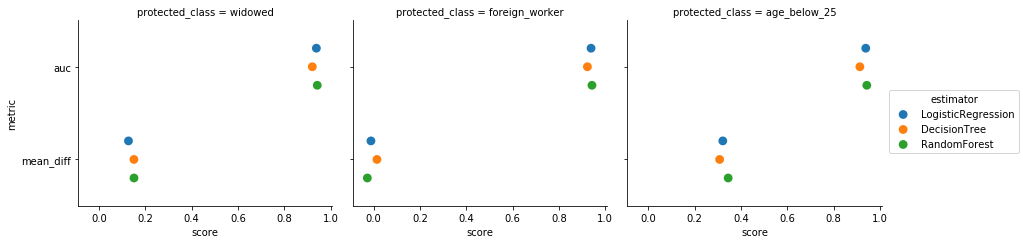

In [11]:
u.plot_experiment_results(experiment_baseline[0])

In [12]:
#################################################
# Naive Fairness-aware Approach: Remove Protected Class
#################################################

# create feature sets that remove variables with protected class information
feature_set_no_widowed = [
    f for f in feature_set_1 if
    f not in [
        'marital_stat_divorced',
        'marital_stat_married-a_f_spouse_present',
        'marital_stat_married-civilian_spouse_present',
        'marital_stat_married-spouse_absent',
        'marital_stat_never_married',
        'marital_stat_separated',
        'marital_stat_widowed',]]
feature_set_no_foreign = [
    f for f in feature_set_1 if
    f not in [
        'citizenship_foreign_born-_not_a_citizen_of_u_s',
        'citizenship_foreign_born-_u_s_citizen_by_naturalization',
        'citizenship_native-_born_abroad_of_american_parent(s)',
        'citizenship_native-_born_in_puerto_rico_or_u_s_outlying',
        'citizenship_native-_born_in_the_united_states']]
feature_set_no_age = [f for f in feature_set_1 if f != "age_below_25"]

# training and target data
X_train_1 = train_set[feature_set_no_widowed].values
X_test_1 = test_set[feature_set_no_widowed].values
X_no_widowed = [X_train_1, X_test_1]

X_train_1 = train_set[feature_set_no_age].values
X_test_1 = test_set[feature_set_no_age].values
X_no_age = [X_train_1, X_test_1]

X_train_1 = train_set[feature_set_no_foreign].values
X_test_1 = test_set[feature_set_no_foreign].values
X_no_foreign = [X_train_1, X_test_1]

experiment_naive_widowed = u.cross_validation_experiment(estimators, X_no_widowed, y, s_widowed, "widowed", split_by_cloumn=True)
experiment_naive_foreign = u.cross_validation_experiment(estimators, X_no_foreign, y, s_foreign, "foreign_worker", split_by_cloumn=True)
experiment_naive_age_below_25 = u.cross_validation_experiment(estimators, X_no_age, y, s_age_below_25, "age_below_25", split_by_cloumn=True)

Training model LogisticRegression with s=widowed
------------------------------------------------
Training model DecisionTree with s=widowed
------------------------------------------
Training model RandomForest with s=widowed
------------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [13]:
experiment_naive = u.generate_summary(experiment_naive_widowed, experiment_naive_foreign, experiment_naive_age_below_25)
print experiment_naive[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.907493   0.292155
                LogisticRegression test       0.938530   0.321391
                RandomForest       test       0.942622   0.338573
foreign_worker  DecisionTree       test       0.918441   0.019044
                LogisticRegression test       0.938607  -0.025935
                RandomForest       test       0.942755  -0.022344
widowed         DecisionTree       test       0.913252   0.151541
                LogisticRegression test       0.938161   0.126116
                RandomForest       test       0.941943   0.150787


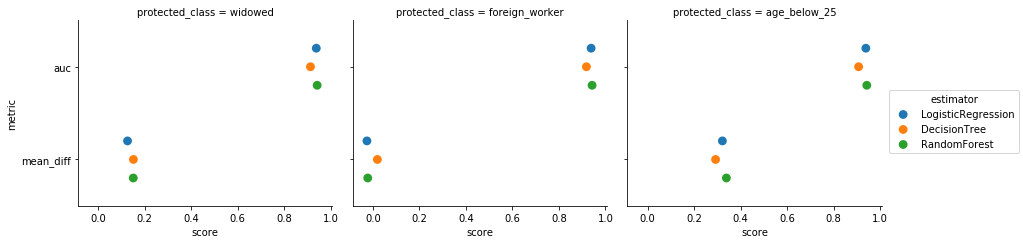

In [14]:
u.plot_experiment_results(experiment_naive[0])

In [15]:
#################################################
# Fairness-aware Method: Relabelling
#################################################

# here we use the relabeller class to create new y vectors for each of the
# protected class contexts.

# we also use the FairnessAwareMetaEstimator as a convenience class to
# compose together different fairness-aware methods. This wraps around the
# estimators that we defined in the previous
relabeller = Relabeller()
relabelling_estimators = [
    (name, FairnessAwareMetaEstimator(e, relabeller=relabeller))
    for name, e in estimators]

experiment_relabel_widowed = u.cross_validation_experiment(relabelling_estimators, X_no_widowed, y, s_widowed, "widowed", split_by_cloumn=True)
experiment_relabel_foreign = u.cross_validation_experiment(relabelling_estimators, X_no_foreign, y, s_foreign, "foreign_worker", split_by_cloumn=True)
experiment_relabel_age_below_25 = u.cross_validation_experiment(relabelling_estimators, X_no_age, y, s_age_below_25, "age_below_25", split_by_cloumn=True)

Training model LogisticRegression with s=widowed
------------------------------------------------
Training model DecisionTree with s=widowed
------------------------------------------
Training model RandomForest with s=widowed
------------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [16]:
experiment_relabel = u.generate_summary(experiment_relabel_widowed, experiment_relabel_foreign, experiment_relabel_age_below_25)
print experiment_relabel[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.873079   0.182283
                LogisticRegression test       0.895155   0.162596
                RandomForest       test       0.908286   0.066762
foreign_worker  DecisionTree       test       0.502801  -0.360898
                LogisticRegression test       0.623427  -0.372931
                RandomForest       test       0.570604  -0.436782
widowed         DecisionTree       test       0.918703   0.136080
                LogisticRegression test       0.938163   0.119363
                RandomForest       test       0.941413   0.147726


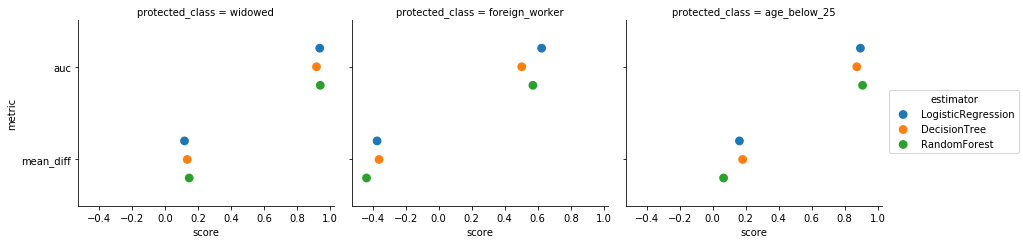

In [17]:
u.plot_experiment_results(experiment_relabel[0])

In [18]:
#################################################
# Fairness-aware Method: Additive Counterfactually Fair Model
#################################################

LINEAR_REG = LinearRegression()
DECISION_TREE_REG = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)
RANDOM_FOREST_REG = RandomForestRegressor(
    n_estimators=50, max_depth=10, min_samples_leaf=10)

# use the estimators defined above to define the linear additive
# counterfactually fair models
linear_acf_estimators = [
    (name, LinearACFClassifier(
         target_estimator=e,
         binary_residual_type="absolute"))
    for name, e in estimators]

experiment_acf_widowed = u.cross_validation_experiment(linear_acf_estimators, X_no_widowed, y, s_widowed, "widowed", split_by_cloumn=True)
experiment_acf_foreign = u.cross_validation_experiment(linear_acf_estimators, X_no_foreign, y, s_foreign, "foreign_worker", split_by_cloumn=True)
experiment_acf_age_below_25 = u.cross_validation_experiment(linear_acf_estimators, X_no_age, y, s_age_below_25, "age_below_25", split_by_cloumn=True)

Training model LogisticRegression with s=widowed
------------------------------------------------
Training model DecisionTree with s=widowed
------------------------------------------
Training model RandomForest with s=widowed
------------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [19]:
experiment_acf = u.generate_summary(experiment_acf_widowed, experiment_acf_foreign, experiment_acf_age_below_25)
print experiment_acf[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.899702   0.444323
                LogisticRegression test       0.913038   0.161421
                RandomForest       test       0.941447   0.357466
foreign_worker  DecisionTree       test       0.922238  -0.026835
                LogisticRegression test       0.939789  -0.045269
                RandomForest       test       0.942491  -0.057012
widowed         DecisionTree       test       0.925018   0.153878
                LogisticRegression test       0.938918   0.130610
                RandomForest       test       0.942290   0.161974


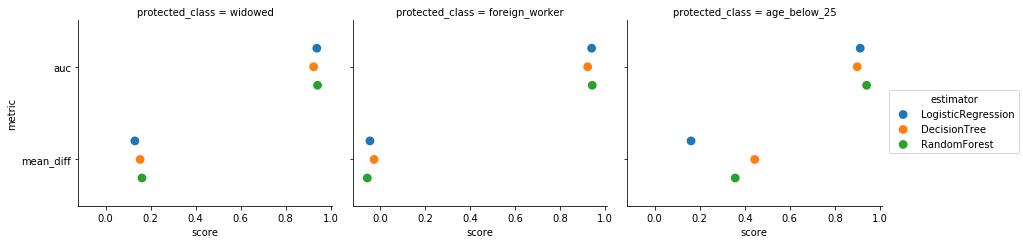

In [20]:
u.plot_experiment_results(experiment_acf[0])

In [21]:
#################################################
# Reject-option Classification
#################################################

# use the estimators defined above to define the linear additive
# counterfactually fair models
single_roc_clf_estimators = [
    (name, SingleROClassifier(estimator=e))
    for name, e in estimators]

experiment_single_roc_widowed = u.cross_validation_experiment(single_roc_clf_estimators, X_no_widowed, y, s_widowed, "widowed", split_by_cloumn=True)
experiment_single_roc_foreign = u.cross_validation_experiment(single_roc_clf_estimators, X_no_foreign, y, s_foreign, "foreign_worker", split_by_cloumn=True)
experiment_single_roc_age_below_25 = u.cross_validation_experiment(single_roc_clf_estimators, X_no_age, y, s_age_below_25, "age_below_25", split_by_cloumn=True)

Training model LogisticRegression with s=widowed
------------------------------------------------
Training model DecisionTree with s=widowed
------------------------------------------
Training model RandomForest with s=widowed
------------------------------------------
Training model LogisticRegression with s=foreign_worker
-------------------------------------------------------
Training model DecisionTree with s=foreign_worker
-------------------------------------------------
Training model RandomForest with s=foreign_worker
-------------------------------------------------
Training model LogisticRegression with s=age_below_25
-----------------------------------------------------
Training model DecisionTree with s=age_below_25
-----------------------------------------------
Training model RandomForest with s=age_below_25
-----------------------------------------------


In [22]:
experiment_single_roc = u.generate_summary(experiment_single_roc_widowed, experiment_single_roc_foreign, experiment_single_roc_age_below_25)
print experiment_single_roc[1]

                                                   auc  mean_diff
protected_class estimator          fold_type                     
age_below_25    DecisionTree       test       0.908426   0.355251
                LogisticRegression test       0.936338   0.311326
                RandomForest       test       0.939902   0.339770
foreign_worker  DecisionTree       test       0.903789   0.044333
                LogisticRegression test       0.936372  -0.025594
                RandomForest       test       0.940801  -0.008923
widowed         DecisionTree       test       0.908648   0.095357
                LogisticRegression test       0.935936   0.126262
                RandomForest       test       0.938998   0.144767


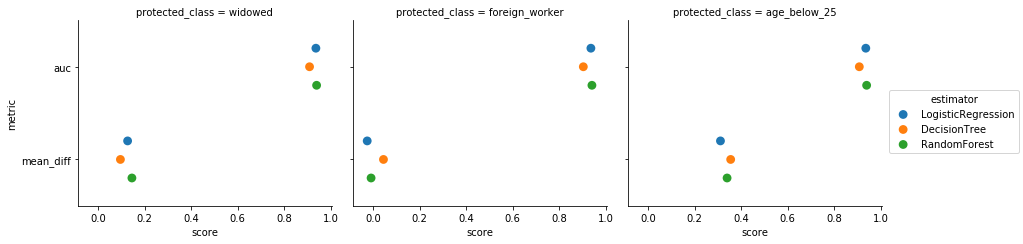

In [23]:
u.plot_experiment_results(experiment_single_roc[0])

In [24]:
#################################################
# Comparison
#################################################

compare_experiments = u.comparison(experiment_baseline[0], experiment_naive[0], experiment_relabel[0], experiment_acf[0], experiment_single_roc[0])

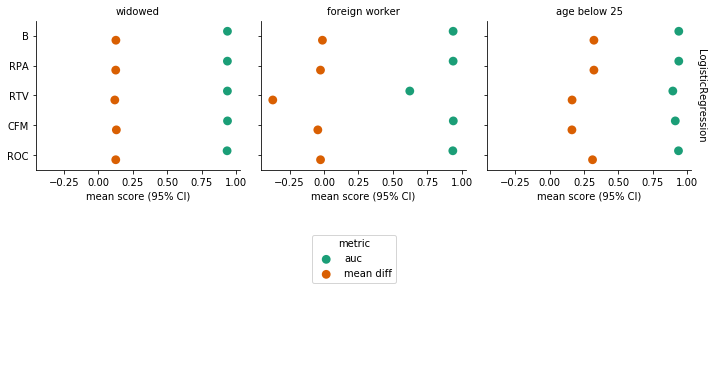

In [25]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'LogisticRegression'"))

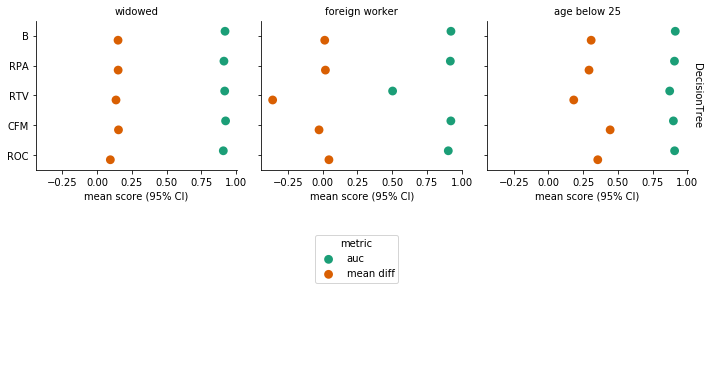

In [26]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'DecisionTree'"))

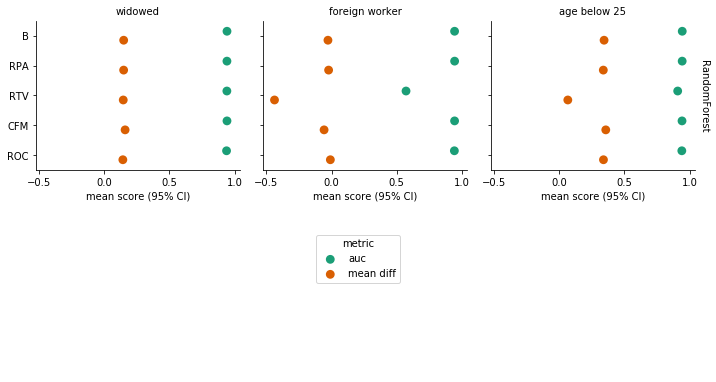

In [27]:
u.compare_experiment_results_multiple_model(compare_experiments.query("estimator == 'RandomForest'"))